In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from k_means import *

### Data loading

In [5]:
root = "/home/dikra/media/dikra/PhD/DATA/DLC24_Data/tiny_all_bird_merged_coco"
images = f"{root}/images"
annotations = f"{root}/annotations"

In [6]:
train_file = open(f"{annotations}/train.json")
test_file = open(f"{annotations}/test.json")
train_data = json.load(train_file)
test_data = json.load(test_file)

In [7]:
train_ann = len(train_data["annotations"])
f"{train_ann} Annotated train images"

'414 Annotated train images'

In [8]:
cats = train_data["categories"][0]["keypoints"]
cats_dict = dict(zip(range(0, len(cats)), cats))
cats_dict

{0: 'back',
 1: 'bill',
 2: 'belly',
 3: 'breast',
 4: 'crown',
 5: 'forehead',
 6: 'left_eye',
 7: 'left_leg',
 8: 'left_wing_tip',
 9: 'left_wrist',
 10: 'nape',
 11: 'right_eye',
 12: 'right_leg',
 13: 'right_wing_tip',
 14: 'right_wrist',
 15: 'tail_tip',
 16: 'throat',
 17: 'neck',
 18: 'tail_left',
 19: 'tail_right',
 20: 'upper_spine',
 21: 'upper_half_spine',
 22: 'lower_half_spine',
 23: 'right_foot',
 24: 'left_foot',
 25: 'left_half_chest',
 26: 'right_half_chest',
 27: 'chin',
 28: 'left_tibia',
 29: 'right_tibia',
 30: 'lower_spine',
 31: 'upper_half_neck',
 32: 'lower_half_neck',
 33: 'left_chest',
 34: 'right_chest',
 35: 'upper_neck',
 36: 'left_wing_shoulder',
 37: 'left_wing_elbow',
 38: 'right_wing_shoulder',
 39: 'right_wing_elbow',
 40: 'upper_cere',
 41: 'lower_cere'}

### Data prep

In [9]:
all_keypoints = get_all_keypoints(train_data)  # load all keypoint annotations
parsed_keypoints = keypoint2vec(all_keypoints)  # parse keypoint annotations into (x, y, visibility) triples

parsed_keypoints, parsed_keypoints.shape

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [514., 304.,   0., ...,   0.,   0.,   0.],
        [368., 162.,   0., ...,   0.,   0.,   0.]]),
 (414, 126))

In [10]:
df = pd.DataFrame(parsed_keypoints)
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,361.0,586.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,650.0,186.0,0.0,462.0,233.0,0.0,700.0,324.0,0.0,597.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.0,1369.0,389.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# drop all zero features: keypoints that are never annotated
df = df.loc[:, (df != 0).any(axis=0)]
df

,0,1,3,4,5,6,7,9,10,12,...,49,51,52,53,69,70,71,72,73,74
0,0.0,0.0,160.0,358.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,168.0,364.0,2.0,168.0,399.0,2.0,182.0,399.0,2.0
1,0.0,0.0,257.0,328.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,271.0,339.0,2.0,279.0,387.0,2.0,289.0,389.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,353.0,334.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,391.0,325.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,375.0,367.0,2.0,367.0,364.0,2.0
4,0.0,0.0,426.0,332.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,420.0,337.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,364.0,410.0,139.0,186.0,0.0,357.0,639.0,293.0,469.0,290.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,437.0,208.0,657.0,210.0,0.0,422.0,408.0,526.0,333.0,553.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,0.0,0.0,305.0,156.0,0.0,238.0,182.0,266.0,158.0,293.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,514.0,304.0,328.0,271.0,0.0,538.0,415.0,435.0,382.0,429.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# compute correlation between remaining features
corr = np.corrcoef(df.T)

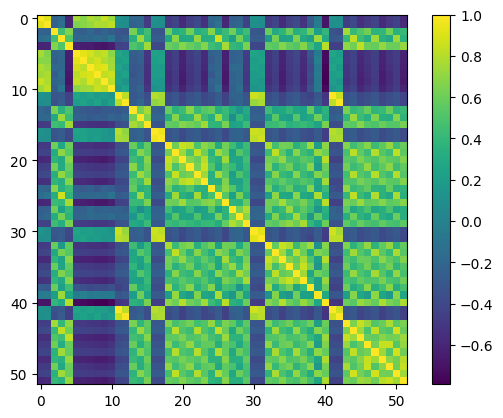

In [13]:
plt.imshow(corr)
plt.colorbar()

### PCA

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

In [44]:
pca_3d = PCA(n_components=3)
pca_2d = PCA(n_components=2)

p_comp_2d = pca_2d.fit_transform(scaled_features)
p_comp_3d = pca_3d.fit_transform(scaled_features)

p_comp_2d.shape, p_comp_3d.shape

((414, 2), (414, 3))

### KMeans clustering

#### Kmeans on 2d features

##### Deciding on number of clusters: elbow method

In [49]:
sse = [] # sum of squared error within clusters
for k in range(1, 15):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=50, random_state=42)
    # run Kmeans algo
    kmeans.fit(p_comp_2d)
    sse.append(kmeans.inertia_)

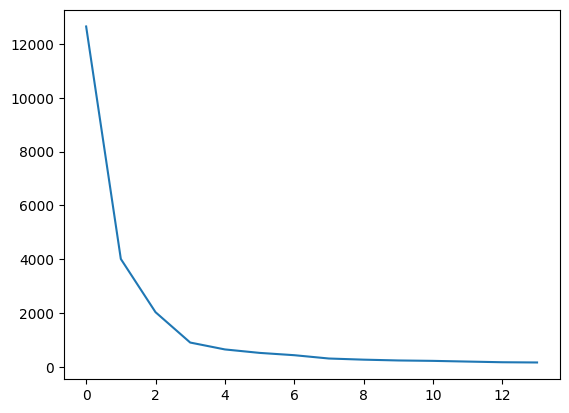

In [50]:
plt.plot(sse)

In [51]:
from kneed import KneeLocator

opt_clusters = KneeLocator(range(1,15), sse, curve="convex", direction="decreasing")
f"Optimal number of clusters: {opt_clusters.knee}"

'Optimal number of clusters: 4'

In [59]:
kmeans = KMeans(init="random", n_clusters=opt_clusters.knee, n_init=10, max_iter=50, random_state=42)
# run Kmeans algo
kmeans.fit(p_comp_2d)

predicted_labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [60]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(p_comp_2d, predicted_labels)
predicted_clusters

,0,1,label
3,-0.006787,0.560821,3
3,2.449607,0.411817,3
3,-0.402650,0.643910,3
3,1.341815,0.619687,3
3,0.271036,0.516926,3
...,...,...,...
1,-4.467823,-4.027202,1
1,-4.408312,-3.744752,1
1,-3.339419,-1.204283,1
1,-4.626191,-4.027216,1


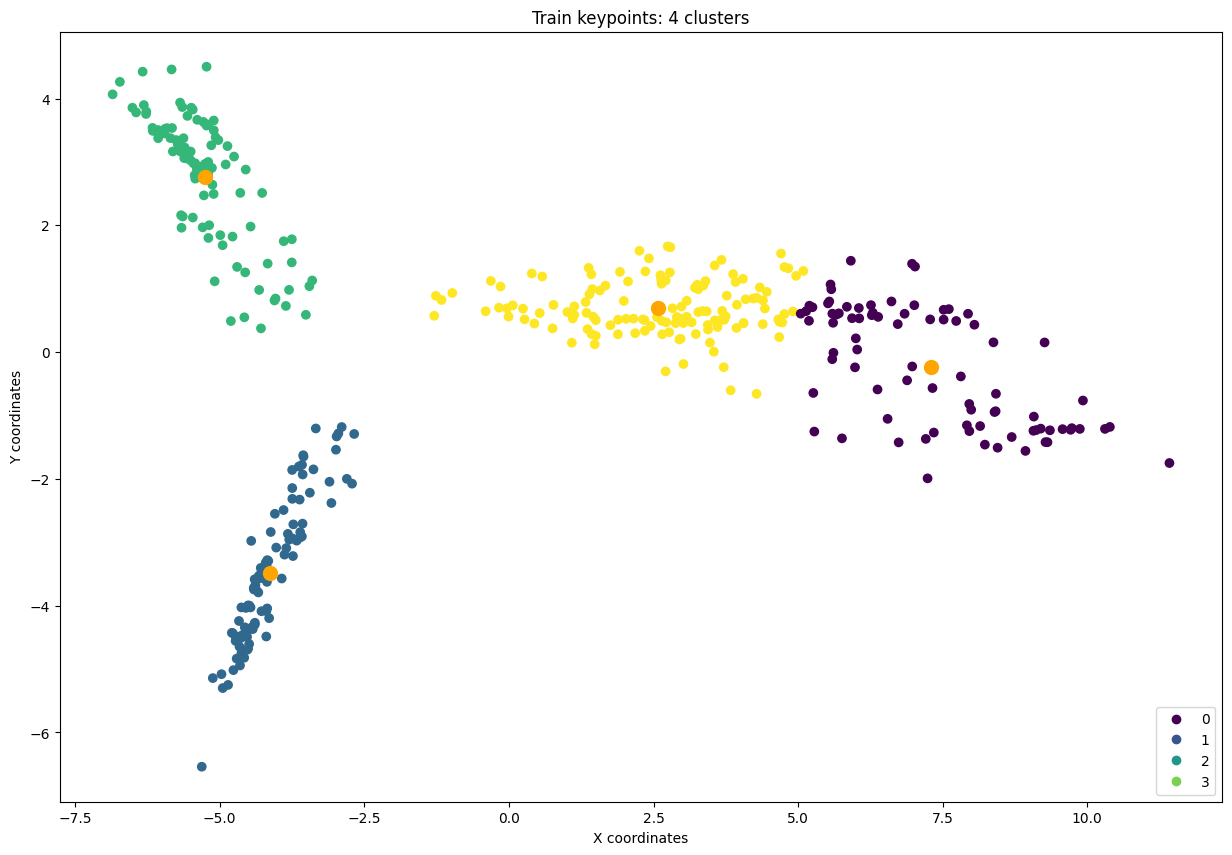

In [70]:
plt.figure(figsize=(15, 10))
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")

unique_labels = np.unique(predicted_clusters["label"])
handles, labels = scatter.legend_elements(prop="colors", num=len(unique_labels))
scatter = plt.scatter(predicted_clusters[0], predicted_clusters[1], c=predicted_clusters["label"])
plt.legend(handles, unique_labels, loc="lower right")
plt.title(f"Train keypoints: {opt_clusters.knee} clusters")
scatter2 = plt.scatter(centers[:, 0], centers[:, 1], c="orange", s=100)

#### Kmeans on 3d features

In [71]:
sse = [] # sum of squared error within clusters
for k in range(1, 15):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=50, random_state=42)
    # run Kmeans algo
    kmeans.fit(p_comp_3d)
    sse.append(kmeans.inertia_)

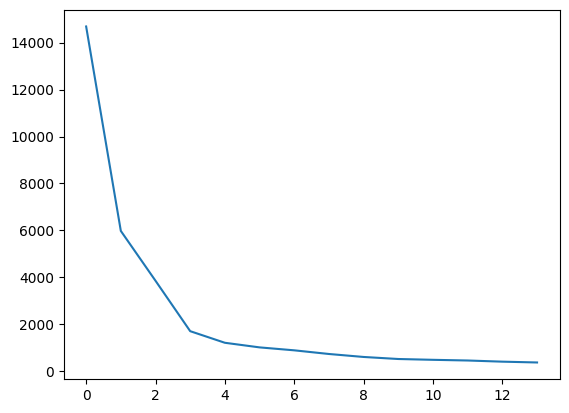

In [72]:
plt.plot(sse)

In [73]:
from kneed import KneeLocator

opt_clusters = KneeLocator(range(1,15), sse, curve="convex", direction="decreasing")
f"Optimal number of clusters: {opt_clusters.knee}"

'Optimal number of clusters: 4'

In [74]:
kmeans = KMeans(init="random", n_clusters=opt_clusters.knee, n_init=10, max_iter=50, random_state=42)
# run Kmeans algo
kmeans.fit(p_comp_3d)

predicted_labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [76]:
# Construct dataframe from predicted clusters
predicted_clusters = to_df(p_comp_3d, predicted_labels)
predicted_clusters

,0,1,2,label
3,-0.006787,0.560821,-0.939724,3
3,2.449607,0.411817,-0.268492,3
3,-0.402650,0.643910,-1.652101,3
3,1.341815,0.619687,-1.302087,3
3,0.271036,0.516926,-1.538147,3
...,...,...,...,...
1,-4.467823,-4.027202,0.194285,1
1,-4.408312,-3.744752,-0.273688,1
1,-3.339419,-1.204283,-1.303910,1
1,-4.626191,-4.027216,-0.329286,1


In [77]:
import plotly.express as px

fig = px.scatter_3d(predicted_clusters, x=0, y=1, z=2, color='label')
fig.show()

In [ ]:
# TODO implement hover functionality on plots to visualise corresponding image